# Quality Control

## Motivation

(To be refined) A crucial part of every single-cell analysis, is the removal of low-quality cells, so they don't add non-meaningful noise to our downstrem analysis. scATAC data is even more sparse than scRNA-seq data with onyl 1-10% of genes detected in each cell. Therefore, low sequencing depth per cell or other quality issues can lead to uninformative analysis outcomes.

## Dataset

To showcase the processing of scATAC-seq data, we use a 10x Multiome data set generated for the single cell data integration challenge at the NeurIPS conference 2021 {cite:p}`luecken2021sandbox`. A hallmark of this data set is that it contains a nested batch structure of multiple donors sequenced at multiple institutions. Approaches for processing multiple smaples simultaneously are given in the integration chapter, here we describe the preprocessing of one sample.

(To be added?) Note on feature harmonization by ```cellranger-arc aggr```, which harmonizes features (peaks) across all samples within our analysis.

Our starting point for this notebook is the output of ```cellranger-arc```, the software solution of 10x to perfom alignment, peak calling and initial QC of their 10x Multiome assay.  By default, the output contains the snRNA-seq as well as the scATAC-seq data. Since the preprocessing of scRNA-seq or snRNA-seq data has been described extensively in previous chapters, here, we load the multimodal data, but only discuss the processing of the chromatin accesibility data.


The primary file we load is the filtered_feature_bc_matrix.h5 file containing the cell-by-peak count matrix. During loading, we leverage the functionality of ```moun``` to automatically detect the corresponding fragment and peak annotation files within the same directory.

In [92]:
import os
import scanpy as sc
import muon as mu
from muon import atac as ac   # the module containing function for scATAC data processing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting figure parameters
sc.settings.verbosity = 0

from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [4.5,4.5]
sns.set_style("whitegrid")

In [2]:
# Check the current working directory
os.getcwd()

'/Users/christopher.lance/PhD/projects/single-cell-best-practices/jupyter-book/chromatin_accessibility'

In [3]:
# In case you would like to change the working directory
os.chdir('/Users/christopher.lance/PhD/projects/single-cell-best-practices/jupyter-book/chromatin_accessibility')

In [4]:
# Load the data by pointing to the .h5 file of the cellranger output
mdata = mu.read_10x_h5("resources/cellranger_out/filtered_feature_bc_matrix.h5")

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from resources/cellranger_out/filtered_feature_bc_matrix.h5


/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from resources/cellranger_out/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: resources/cellranger_out/atac_fragments.tsv.gz


As the warning messages indicate, peak identifiers are not unique. To prevent issues in downstrem analysis steps, we make them unique using the ```.var_names_make_unique()``` function.

In [5]:
mdata.var_names_make_unique()

Next, let's take a look into the MuData object we just generated (the data structure is described in detail in chapter 4.4.).

In [6]:
mdata

MuData object with n_obs × n_vars = 16934 × 190628
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	16934 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	16934 x 154027
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

Both modalities (RNA and ATAC) have been loaded as two AnnData objects. In total 16934 cells were loaded and 36601 genes and 154027 peaks for RNA and ATAC, respectively. The ATAC modality additionally contains two entries in the unstructured data slot ```atac.uns``` that contain the peak annotation and the path to the fragment file automatically located by muon.

Let's take a look at the ```atac.uns``` slot, printing the peak annotation and path to the fragment file.

In [7]:
mdata.mod['atac'].uns

OverloadedDict, wrapping:
	OrderedDict([('atac', {'peak_annotation':                                peak  distance peak_type
gene_name                                              
MIR1302-2HG         chr1:9763-10648    -18906    distal
AL627309.1       chr1:115270-116168      4764    distal
AL627309.5       chr1:181107-181768     -7246    distal
AL627309.5       chr1:183973-184845    -10112    distal
AL627309.5       chr1:191237-192111    -17376    distal
...                             ...       ...       ...
AC213203.2   KI270713.1:21361-22256     10272    distal
AC213203.2   KI270713.1:29645-30508      2020    distal
AC213203.2   KI270713.1:32401-33088         0  promoter
AC213203.1   KI270713.1:34369-35136      -271  promoter
AC213203.1   KI270713.1:36970-37884      1564    distal

[196633 rows x 3 columns]}), ('files', {'fragments': 'resources/cellranger_out/atac_fragments.tsv.gz'})])
With overloaded keys:
	['neighbors'].

By loading the peak annotation file provided as part of the cellranger output we already have a first idea which genes might be affected by a given peak. However, this is only based on the distance to the closest gene and should be considered with care.

For subsequent processing we extract the atac Anndata object:

In [8]:
atac = mdata.mod['atac']

## Doublet detection

The sparcity of scATAC data is considerably higher compared to scRNA data. Therefore, it is not recommended to directly apply methods developed for scRNA-seq on scATAC data. Here, we describe the use of two orthogonal methods for doublet scoring which can subsequently be used to detect clusters of cells containing doublets. Both approaches have been implemented in the R package scDoubletFinder {cite:t}`germain2021doublet` and code was adapted from [this tutorial](https://www.bioconductor.org/packages/devel/bioc/vignettes/scDblFinder/inst/doc/scATAC.html).

- **Approach 1: Doublet Scoring based on simulated doublets:** The native scDoubletFinder method is leveraging simulated doublets to assign doublet scores. Prior to generating doublets highly correlated features are aggregated to reduce sparcity and the number features. As with methods for scRNA-data, this method detects heterotypic doublets.
- **Approach 2: Coverage-based doublet scoring using AMULET** {cite:t}`thibodeau2021amulet`: This doublet scoring method is based on the number of counts larger 2 for a given position in the genome. Since DNA is only present as two copies in a diploid organisms, one can expect a maximum count of two for any given position in the genome. This method performs best, with sufficient sequencing depth (> 10-15k reads per cell) and can additionally capture homotypic doublets.


**(Add figure)**


**(Remove?)** An alternative method with comparable performance is the doublet detection implemented in ArchR.

**(Add description of loading R etc.)**

In [48]:
# Activate R
import rpy2.rinterface_lib.callbacks
import logging
#
from rpy2.robjects import pandas2ri
import anndata2ri

In [10]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()

In [11]:
%load_ext rpy2.ipython

Ensure the right libPath

In [12]:
%%R
.libPaths()

[1] "/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/R/library"


In [13]:
%%R
suppressPackageStartupMessages(library(scDblFinder))
suppressPackageStartupMessages(library(SingleCellExperiment))

### Count-based doublet scoring

Since the doublet scoring can take some time we save the output as a seperate file.

In [14]:
# Set output paths
save_path_dir = 'output/doublet_scores/'
sample_ident = 's4d8'

In [14]:
barcodes = list(atac.obs_names)
data_mat = atac.X.T.A

**(Improve description of paramaters)** In the following cell, we create a single cell experiment object, aggregate highly correlated features and normalize them by... clusters-based scoring is recommended if well-distinguishable cell populations are expected (e.g.PBMCs), while it is not recommended if contineous trajectories are expected.

In [17]:
%R -i data_mat -o dbl_score sce <- scDblFinder(SingleCellExperiment(list(counts=data_mat)), \
                                               clusters=TRUE, aggregateFeatures=TRUE, nfeatures=1000, \
                                               processing="normFeatures"); dbl_score <- sce$scDblFinder.score

In [19]:
scDbl_result = pd.DataFrame({"barcodes":barcodes, "scDblFinder_score":dbl_score})
scDbl_result.to_csv(save_path_dir+'/scDblFinder_scores_'+sample_ident+'.csv')

In [24]:
# To load from file
# scDbl_result = pd.read_csv(save_path_dir+'/scDblFinder_scores_'+sample_ident+'.csv',
#                          index_col=0)

In [26]:
scDbl_result = scDbl_result.set_index('barcodes')

In [27]:
# Checking the results
scDbl_result.head()

,scDblFinder_score
barcodes,
AAACAGCCAAGCTTAT-1,0.001987
AAACAGCCATAGCTTG-1,0.000023
AAACAGCCATGAAATG-1,0.007280
AAACAGCCATGTTTGG-1,0.001401
AAACATGCAACGTGCT-1,0.052145


In [28]:
# Adding scDbltFinder scores to the atac Anndata object
atac.obs['scDblFinder_score'] = scDbl_result['scDblFinder_score']

### Coverage-based doublet scoring

Since AMULTET estimates doublet scores based on the number of positions with more than two counts, we exclude repetitive regions, mitochondrial genes and sex chromosomes, as suggested by {cite:t}`thibodeau2021amulet`. Note that for this sample with about 16k cells AMULET takes about 4 hours to run on a personal computer.

**(describe steps bit more in detail, e.g. repeat elements)**

In [15]:
%%R

# Set up a GRanges objects of repeat elements, mitochondrial genes and sex chromosomes
suppressPackageStartupMessages(library(GenomicRanges))
repeats <- GRanges("chr6", IRanges(1000,2000))
otherChroms <- GRanges(c("M","chrM","MT","X","Y","chrX","chrY"),IRanges(1L,width=10^8))
toExclude <- suppressWarnings(c(repeats, otherChroms))

In [16]:
# Get the path to the fragment file
frag_path = atac.uns['files']['fragments']
frag_path

'resources/cellranger_out/atac_fragments.tsv.gz'

In [17]:
# Run AMULET
%R -i frag_path -o amulet_result amulet_result <- amulet(frag_path, regionsToExclude=toExclude)

# save output
amulet_result.to_csv(save_path_dir+'/AMULET_scores_'+sample_ident+'.csv')

R[write to console]: 01:35:14 - Reading Tabix-indexed fragment file and computing overlaps



chr1, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr2, chr20, chr21, chr22, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chrX, chrY, KI270728.1, KI270727.1, GL000009.2, GL000194.1, GL000205.2, GL000195.1, GL000219.1, KI270734.1, GL000213.1, GL000218.1, KI270731.1, KI270721.1, KI270726.1, KI270711.1, KI270713.1, 


R[write to console]: 05:22:27 - Merging



In [19]:
# Checking the results
amulet_result.head()

,nFrags,uniqFrags,nAbove2,total.nAbove2,p.value,q.value
AAACAGCCAAGCTTAT-1,2793.0,2793.0,1.0,1.0,0.997045,0.999673
AAACAGCCATGAAATG-1,4123.0,4123.0,1.0,5.0,0.997045,0.999673
AAACAGCCATGTTTGG-1,5520.0,5520.0,2.0,12.0,0.986502,0.999673
AAACATGCAACGTGCT-1,6304.0,6304.0,0.0,4.0,0.999673,0.999673
AAACATGCAATATAGG-1,6614.0,6614.0,1.0,5.0,0.997045,0.999673


In [39]:
# Adding doublet scores to the original atac object:
atac.obs['AMULET_pVal'] = amulet_result['p.value']
atac.obs['AMULET_qVal'] = amulet_result['q.value']

In [39]:
# Transfor q-value for plotting
atac.obs['AMULET_negLog10qVal'] = -1*np.log10(amulet_result['q.value'])

/Users/christopher.lance/mambaforge/envs/scatac_pp/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Let us now plot the scores we derived from the two appraoches.

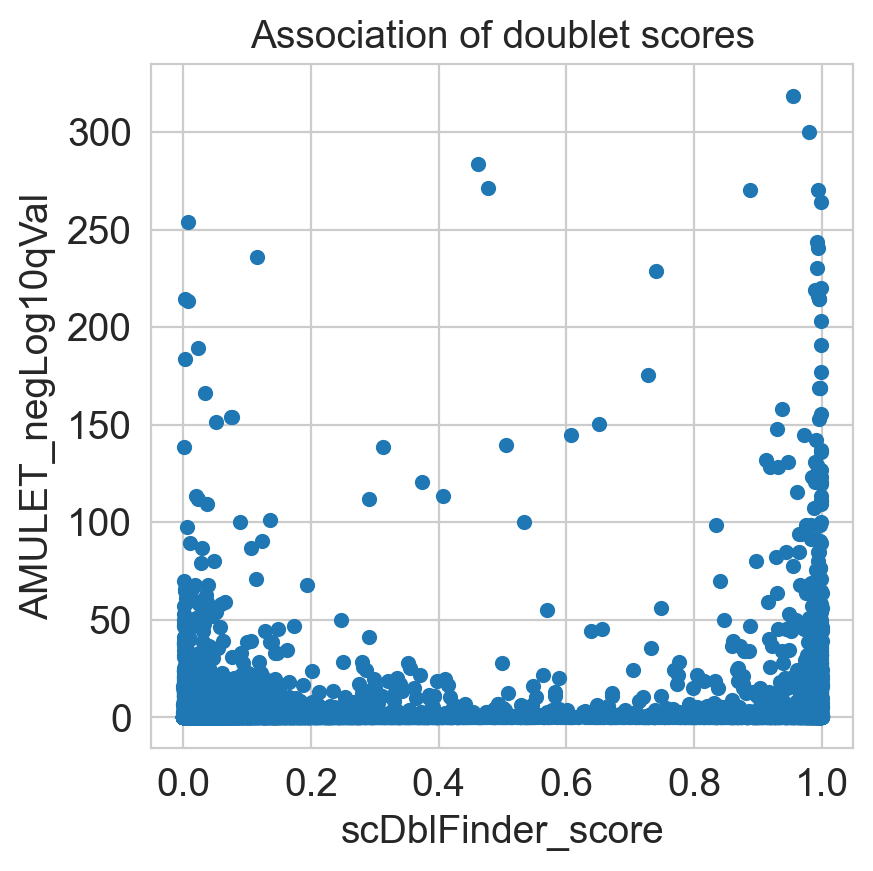

In [93]:
atac.obs.plot(x='scDblFinder_score',
              y='AMULET_negLog10qVal',
              kind='scatter')

plt.title('Association of doublet scores')
plt.show()

Points in the bottom left refer to droplets where AMULET and scDblFinder scores indicate a count distribution and number of positions with more than 2 counts corresponding to singlets. In the top left both scores indicate doublets, while the bottom right corresponds to doublets based on the count distribution (likely heterotypic), while dots in the top left might be homotypic doublets, which are only detected ba AMULET but not count-based methods. We will use both score in a later stepto identify doublet clusters.

## Filtering low quality cells

To detect low quality cells, we need to define metrics, that allow us to seperate high quality from low-quality cells. Here is an overview of the primary QC metrics used across several scATC-seq processing pipelines:
- **total_fragment_counts**: Total number of fragments per cell representing cellular sequencing depth. This metric is analogous to the number of total counts in scRNA-seq data.
- **tss_enrichment**: Transcriptional start site (TSS) enrichment score, which is the ratio of fragments centered at the TSS to fragments in TSS-flanking regions. This metric can be interpreted as a signal-to noise ratio of each cell.
- **n_features_per_cell**: The number of peaks with non-zero counts in each cell. This metric is analogous to the number of genes detected in scRNA-seq data.
- **nucleosome_signal**: The nucleosome signal referes to the ratio of mononucleosomal to nucloesome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell (more details below).

Additional metrics that can be considered:
- **reads_in_peaks_frac:** The fraction of fragments in peak regions versus fragments outside of peaks. Again, an indicator for the signal-to-noise ratio.
- **blacklist_fraction:** The ratio of reads in genomic blacklist regions, which have been associated with artefactual signal (defined by ENCODE). Benchmarking studies of single-cell ATAC-seq data processing have suggested, that often the mapping of reads to blacklist regions is not a major issue {cite:p}`luecken2021sandbox`.

Additionally on can consider the number of cells per sample, as a sample level QC metric.


### Calculating QC metrics

First, we make use of the calculate_qc_metrics function in scanpy to calculate the total number of fragments and number of features per cell. Second, we log-transform the total counts as an additional representation often suitable for plotting. Third, we modify the variable names to make them suitable for scATAC-seq data, i.e. ```total_counts``` becomes ```total_fragment_counts``` and ```n_genes_by_counts``` becomes the more general ```n_features_per_cell```.

### Total count and number of features

In [54]:
# Calculate general qc metrics using scanpy
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

# Rename columns
atac.obs.rename(columns = {'n_genes_by_counts':'n_features_per_cell', 'total_counts':'total_fragment_counts'}, inplace = True)

# log-transform total counts
atac.obs['log_total_fragment_counts'] = np.log10(atac.obs['total_fragment_counts'])

### Nucleosome signal

Next, we calculate scATAC specific QC metrics, the nucleosome signal and TTS enrichment score.

For the nucleosome signal, the default number of fragments n per cell used to calculate the metric is 10e4*n_cells. Since this would take several hours to calculate, we reduce it by a factor of 10, which still returns a good estimate for the metric.

In [57]:
# Calculate the nucleosome signal across cells
ac.tl.nucleosome_signal(atac, n=10e3*atac.n_obs) #set n=10e3*atac.n_obs for rough estimate but faster run time

Reading Fragments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169340000/169340000 [08:56<00:00, 315740.90it/s]


First, let's take a look at the overall distribution of the nucleome signal.

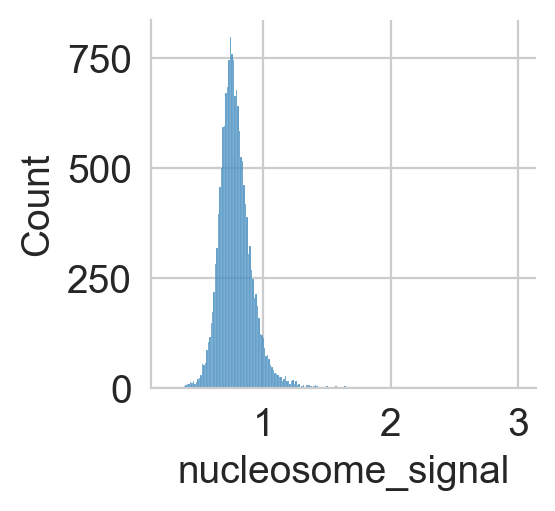

In [94]:
# Plot distribution of the nucleosome_signal across all cells
mu.pl.histogram(atac, "nucleosome_signal", )

# Alternatively as a violin plot (uncomment to plot)
#sc.pl.violin(atac, "nucleosome_signal")

The obtained scores range from 0 to about 3. As a rule of thumb, previous anaylysis projects choose between 2 and 4 as a cut-off for low quality cells. To understand better what this score refers to, let's take a closer look at cells with high versus low nucleosome signals. To do so, we add a column to atac.obs, which contains a category for the two classes and plot the distribution of fragment lengths for each.

In [59]:
# One can check  different nucleosome signal thresholds to see when a difference between high and low quality cells can be observed
nuc_signal_threshold = 2
atac.obs['nuc_signal_filter'] = ['NS_FAIL' if ns > nuc_signal_threshold else 'NS_PASS' for
                                 ns in atac.obs['nucleosome_signal'] ]

# Print number cells not passing nucleosome signal threshold
atac.obs['nuc_signal_filter'].value_counts()

NS_PASS    16877
NS_FAIL       57
Name: nuc_signal_filter, dtype: int64

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


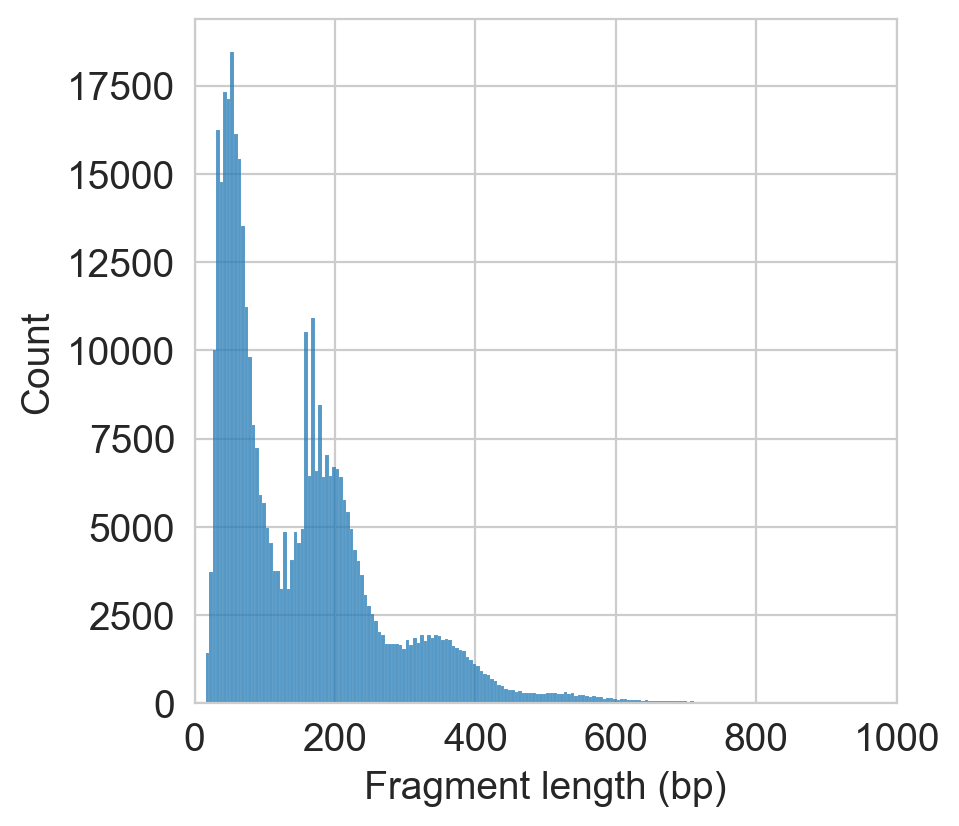

In [95]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_PASS'],
                         region="chr1:1-2000000")

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


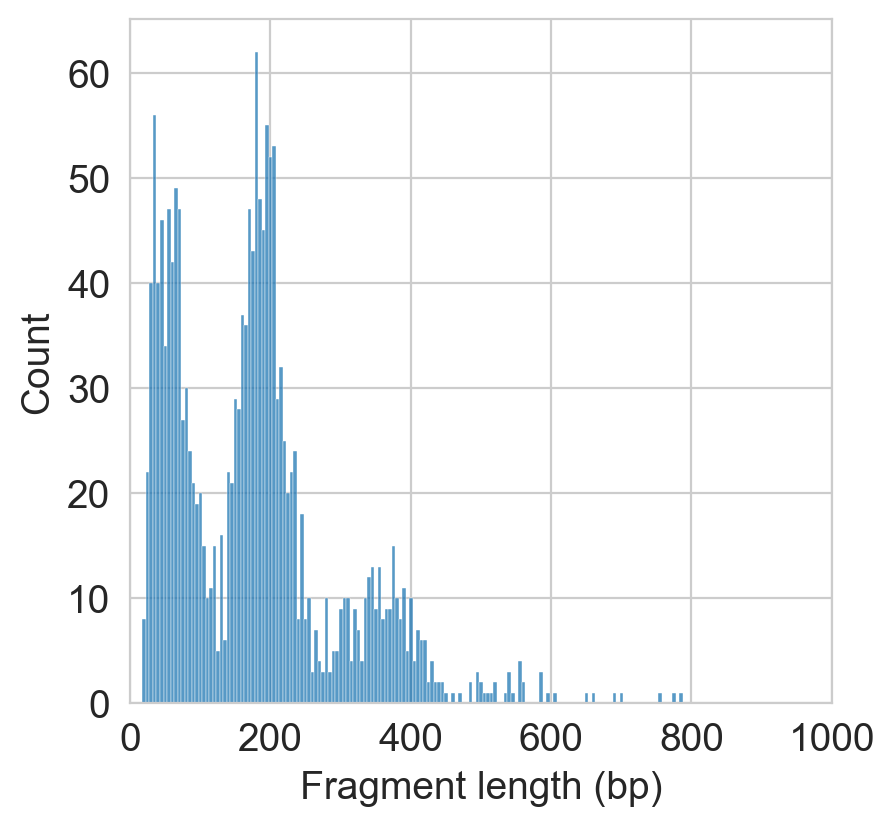

In [96]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_FAIL'],
                         region="chr1:1-2000000") #"chr1:1-2000000"

In the above histograms, we see that the ratio of mononucleosomal to nucleosome-free fragments is unexpectedly high. Therefore we exclude these cells. This quick analysis also shows we are likely working with data with overall good quality, since only 57 cells received a nucleosome signal above 2.

### TSS enrichment

The next QC metric we assess is the signal-to-noise ratio in each cell. To do so, one can calculate the fraction of reads mapped to peak regions or the enrichment of fragments around transcription start sites (TSS). Here we use the later for assessing cell quality.

In [62]:
# calculate TSS enrichment scores (5 min runtime)
# n_tss describes the number of TSS we consider for the estimate of the TSS enrichment score
tss = ac.tl.tss_enrichment(mdata, n_tss=3000)

Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.19it/s]


Note that the line above creates a new ```AnnData``` object, which contains positions from -1000 to +1000 around the TSS, which are considered to calculate the TSS enrichment score. Additionally, a ```tss_score``` is added to the ```atac.obs```  data frame.

We can now plot the distribution of the TSS enrichment score up- and downstream of transciption start sites. For this we imput the newly created tss object to the plotting function.

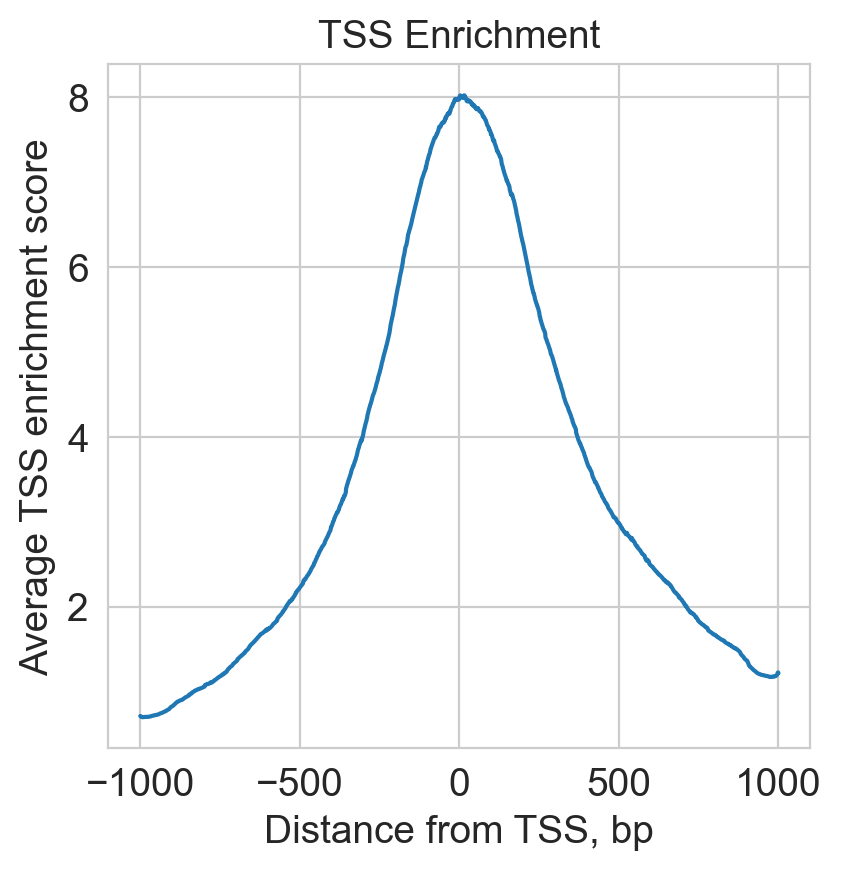

In [97]:
ac.pl.tss_enrichment(tss)

Overall one can see our data shows high enrichment of fragments around the TSS, which is an indicator for good data quality.
Again to see how this might differ in low quality cells, let's plot the enrichment of fragments around a TSS for cell with a low TSS scores. In comparison to the nucleosome signal, where high values represent low quality cells, here, we will filter out cells with a low TSS score.

In [64]:
# Choose threshold for the TSS and add information to atac.obs
tss_threshold = 1.5
tss.obs['tss_filter'] = ['TSS_FAIL' if score < tss_threshold else 'TSS_PASS' for
                                 score in atac.obs['tss_score'] ]

# Print number cells not passing nucleosome signal threshold
tss.obs['tss_filter'].value_counts()

TSS_PASS    16522
TSS_FAIL      412
Name: tss_filter, dtype: int64

In [65]:
# wrapper function to allow fixed y-axis limiters
# makes it easier to compare the two classes of high and low quality cells
def plot_tss_ylim (data, title, ymin, ymax):
    
    _,axis = plt.subplots()
    axis.set_ylim(ymin,ymax)
    ac.pl.tss_enrichment(data, title=title, ax=axis)

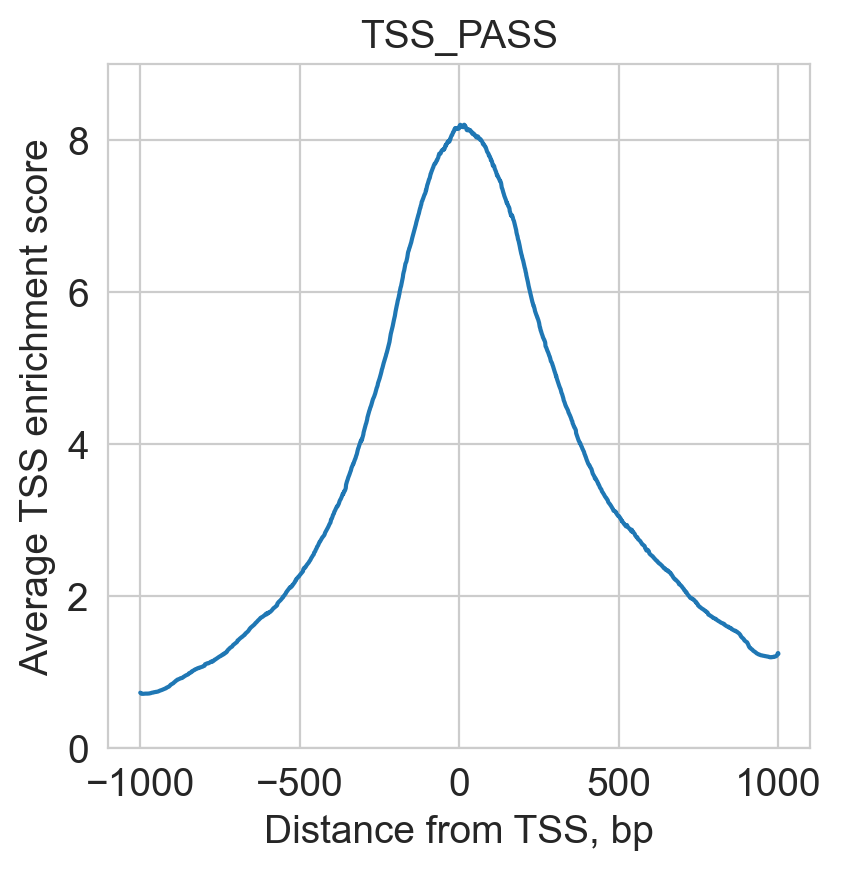

In [98]:
plot_tss_ylim(tss[tss.obs['tss_filter']=='TSS_PASS'], title='TSS_PASS', ymin=0, ymax=9)

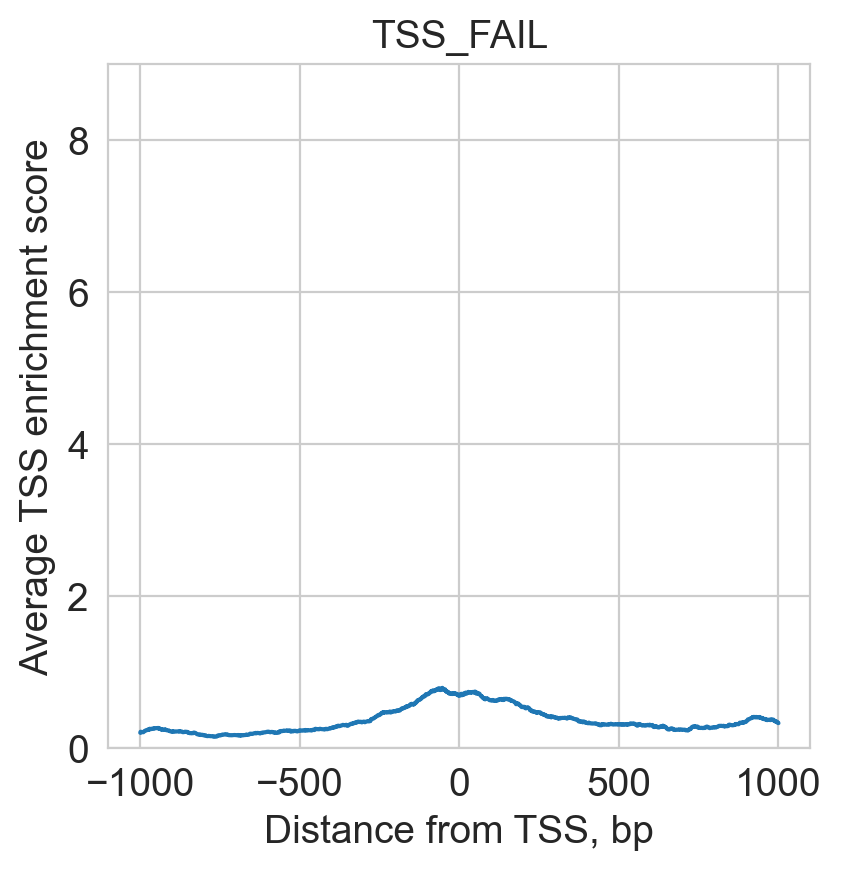

In [99]:
plot_tss_ylim(tss[tss.obs['tss_filter']=='TSS_FAIL'], title='TSS_FAIL', ymin=0, ymax=9)

We can see, how cells with low TSS scores show a much reduced enrichment of fragments around the TSS compared to high quality cells indicating a lower signal to noise ratio.

In [70]:
# Printing the object we're about to save
atac

AnnData object with n_obs × n_vars = 16934 × 154027
    obs: 'AMULET_pVal', 'AMULET_qVal', 'scDblFinder_score', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

Now, let's save the object.

In [71]:
# save after calculation of QC metrics
atac.write_h5ad('output/atac_qc_metrics.h5ad')

## Filtering cells

**The full range of total fragment counts**

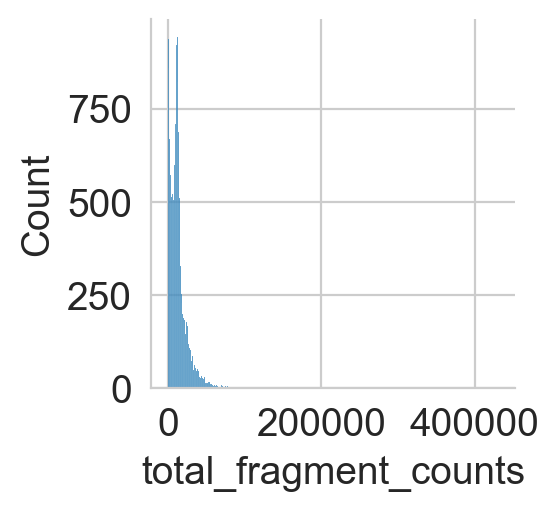

In [100]:
mu.pl.histogram(atac, ['total_fragment_counts'])

This plot gives an overview of the range of the total number of fragments per cell. It becomes clear, that this metric if far from normally distributed and there are outlier cells with extremely high fragment counts that we will filter out.

**Zooming into the low count region**

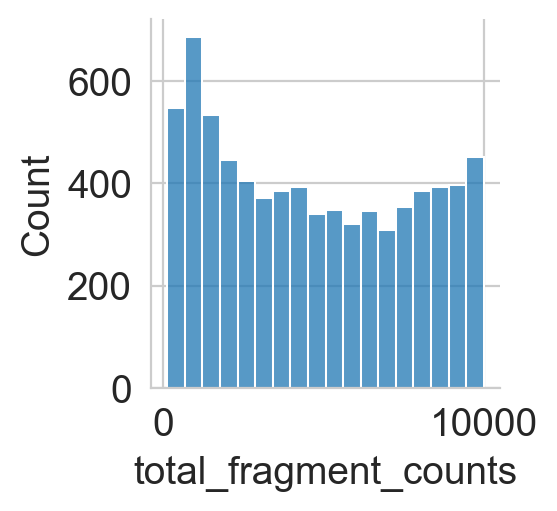

In [101]:
mu.pl.histogram(atac[atac.obs.total_fragment_counts<10000], ['total_fragment_counts'])

**ToDo** Description

**Checking the total number of detected features**

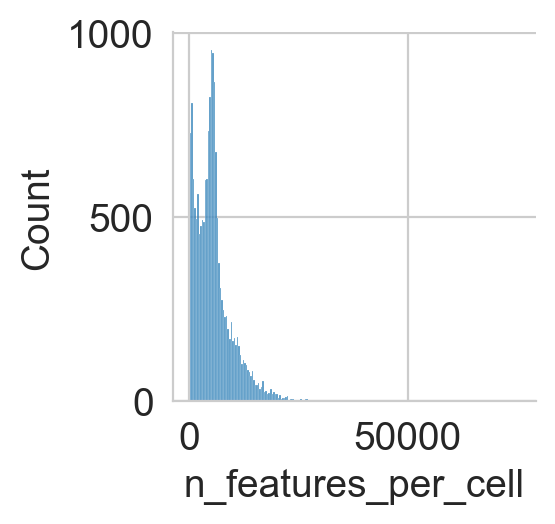

In [102]:
mu.pl.histogram(atac, ['n_features_per_cell'])

**ToDo** Description

**Zooming into the lower counts to decide on lower cut offs**

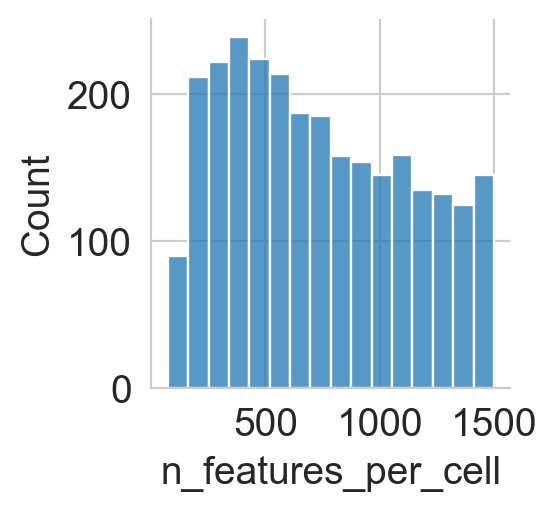

In [104]:
mu.pl.histogram(atac[atac.obs.n_features_per_cell<1500], ['n_features_per_cell'])

**ToDo** Description

To get an additional view mostly useful for the maximum cutoff of total counts, we plot the total fragment count against the total number of features across all samples. This is similar to the standard QC plot used in scRNA data quality control.

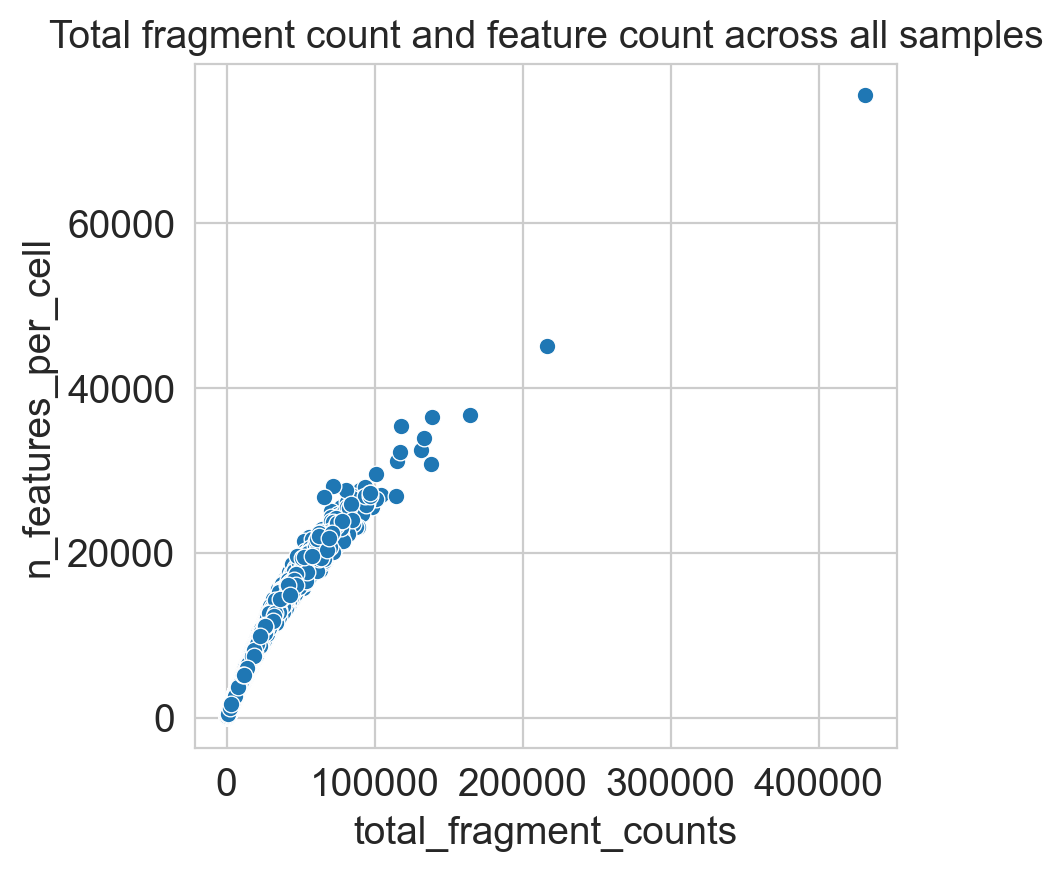

In [106]:
sns.scatterplot(x=atac.obs.total_fragment_counts,
                y=atac.obs.n_features_per_cell)
plt.title('Total fragment count and feature count across all samples')
plt.show()

The most common filtering step in scATAC data is based on the total number of counts plotted against the TSS enrichment score. Here, we chose a 2D hexbin plot. To not overload the notebook we only create the plot for two samples.

**ToDo** Better description

In [107]:
# boundaries for plotting
plot_tss_max = 20

# Initial thresholds
log_count_cutoff_lower = np.log10(1000)
log_count_cutoff_upper = np.log10(300000)
tss_cutoff = 1.5

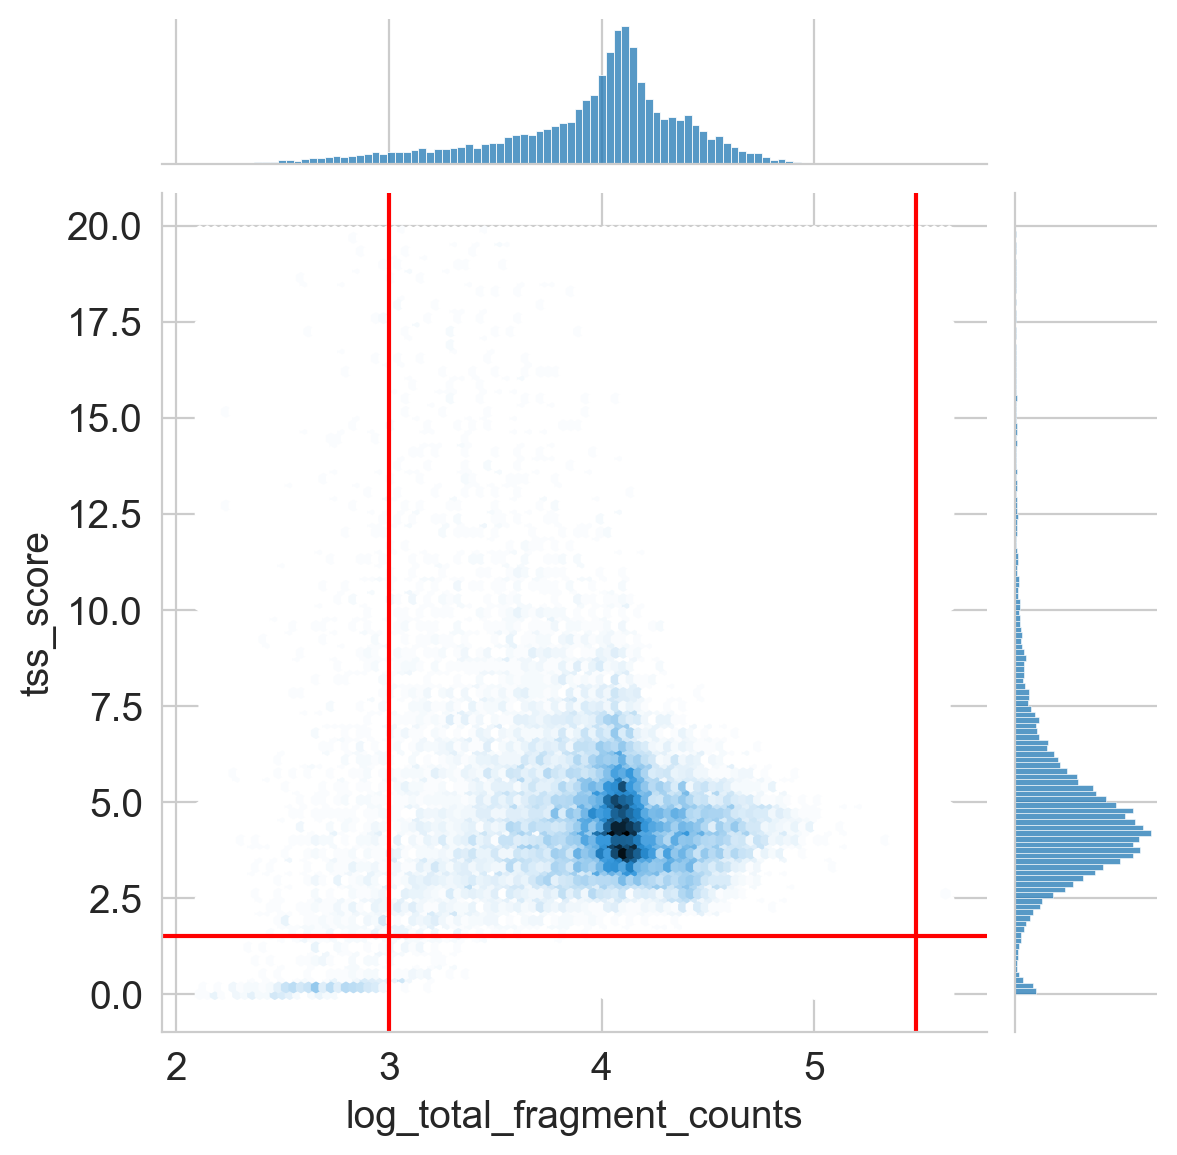

In [109]:

sns.jointplot(data=atac[(atac.obs["tss_score"]<plot_tss_max)].obs,
              x="log_total_fragment_counts",
              y="tss_score",
              kind='hex', gridsize=100)

plt.axvline(x=log_count_cutoff_lower, c='red')
plt.axvline(x=log_count_cutoff_upper, c='red')
plt.axhline(y=tss_cutoff, c='red')

plt.show()

**ToDo** Update description

Across all samples, there is a distinct cluster in the bottom left corner, representing low quality cells. We have the fortunate situation, that thresholds for low quality cells are consitent across samples. This is not always the case, which can lead to different optimal thresholds for different samples.

However as one can see in the two plots above, there is still a difference in distribution of QC metrics between sample (narrow for sample 1, wider for sample 5). This might be an indicator, that sample 5 still contains lower quality cells should be considered in downstream processing tasks such as cell type annotation.

Taken together all the information form the QC plots, we next filter cells accordingly.

After inpecting the distribution of qc metrics, we select thresholds for filtering cells and features as follows:

**ToDo** Better description

- Features (peaks):
    - should be detected in at least 20 cells


In [110]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 20)

**ToDo** Better description and print how much cells were filtered out!

- Cells:
    - number of features per cell > 750
    - number of detected fragments > 1000 and < 300000
    - TSS score > 1.5
    - Nucleosome signal < 2

In [111]:
mu.pp.filter_obs(atac, 'n_features_per_cell', lambda x: x >= 750)
mu.pp.filter_obs(atac, 'log_total_fragment_counts', lambda x: (x >= log_count_cutoff_lower) & (x <= log_count_cutoff_upper))

In [112]:
mu.pp.filter_obs(atac, 'tss_score', lambda x: x >= tss_cutoff)
mu.pp.filter_obs(atac, 'nucleosome_signal', lambda x: x <= 2)

To ensure we keep a version of the raw counts we save them as a seperate layer.

In [113]:
# Save original counts
atac.layers["counts"] = atac.X

In [114]:
atac

AnnData object with n_obs × n_vars = 15345 × 153921
    obs: 'AMULET_pVal', 'AMULET_qVal', 'scDblFinder_score', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'
    layers: 'counts'

Lastly, we save the filtered adata object.

In [115]:
atac.write_h5ad('output/atac_qc_filtered.h5ad')

## Take aways





**ToDo!**